<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_Program_GRU_untuk_Analisis_Sentimen_menggunakan_Dataset_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Program GRU untuk Analisis Sentimen menggunakan Dataset IMDB

### Cell 1: Import Library yang Diperlukan
- Mengimport library NumPy untuk operasi numerik dan Pandas untuk manipulasi data
- Mengimport tools preprocessing dari Keras untuk memproses teks
- Mengimport komponen untuk membangun model neural network dengan layer GRU
- Dataset IMDB sudah tersedia di Keras, berisi 50,000 review film untuk klasifikasi sentimen[2]
- Library matplotlib dan seaborn untuk visualisasi hasil training

In [1]:
# Import library untuk manipulasi data
import numpy as np
import pandas as pd

# Import library untuk preprocessing teks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import library untuk membangun model GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

# Import library untuk dataset IMDB
from tensorflow.keras.datasets import imdb

# Import library untuk visualisasi
import matplotlib.pyplot as plt

# Import library untuk evaluasi model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("Semua library berhasil diimport!")

Semua library berhasil diimport!


### Cell 2: Download dan Load Dataset IMDB
- `vocab_size = 10000` membatasi vocabulary hanya pada 10,000 kata paling sering muncul untuk efisiensi komputasi
- `imdb.load_data()` secara otomatis mendownload dataset IMDB dari server Keras[1]
- Dataset sudah dibagi menjadi training set (25,000 review) dan testing set (25,000 review)
- Setiap review sudah dikonversi menjadi sequence of integers, dimana setiap integer merepresentasikan kata tertentu
- Label 0 untuk sentimen negatif dan 1 untuk sentimen positif


In [2]:
# Mengatur jumlah kata yang akan digunakan dalam vocabulary
vocab_size = 10000  # Menggunakan 10,000 kata paling umum

# Download dan load dataset IMDB
# Dataset akan otomatis di-download jika belum tersedia
print("Mendownload dataset IMDB...")
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")
print(f"\nContoh review pertama (dalam bentuk indeks kata): {X_train[0][:50]}")
print(f"Label review pertama: {y_train[0]} (0=negatif, 1=positif)")

Mendownload dataset IMDB...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Jumlah data training: 25000
Jumlah data testing: 25000

Contoh review pertama (dalam bentuk indeks kata): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447]
Label review pertama: 1 (0=negatif, 1=positif)


### Cell 3: Preprocessing Data
- `max_length = 200` membatasi panjang setiap review menjadi 200 kata untuk konsistensi input
- `pad_sequences()` melakukan padding (menambah 0) atau truncating (memotong) review agar semua memiliki panjang sama[3]
- Parameter `padding='post'` menambahkan 0 di akhir sequence jika review terlalu pendek
- Parameter `truncating='post'` memotong dari akhir jika review terlalu panjang
- Setelah padding, shape menjadi (jumlah_sample, max_length)

In [3]:
# Mengatur panjang maksimum sequence
max_length = 200  # Setiap review akan dipotong/diisi hingga 200 kata

# Padding sequences agar semua review memiliki panjang yang sama
# Padding dilakukan di awal sequence (pre) atau akhir sequence (post)
X_train_pad = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

print(f"Shape data training setelah padding: {X_train_pad.shape}")
print(f"Shape data testing setelah padding: {X_test_pad.shape}")
print(f"\nContoh review setelah padding:")
print(X_train_pad[0])

Shape data training setelah padding: (25000, 200)
Shape data testing setelah padding: (25000, 200)

Contoh review setelah padding:
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  

### Cell 4: Membangun Arsitektur Model GRU
- **Embedding Layer**: Mengkonversi setiap kata (integer) menjadi vector berdimensi 128, memungkinkan model mempelajari representasi kata[4]
- **GRU Layer**: Layer Gated Recurrent Unit dengan 64 units untuk memproses informasi sequential[5]
- Parameter `return_sequences=False` membuat GRU hanya mengembalikan output dari timestep terakhir
- **Dropout Layer**: Menghilangkan 50% neuron secara random saat training untuk mencegah overfitting
- **Dense Layer**: Output layer dengan 1 neuron dan aktivasi sigmoid untuk klasifikasi biner (positif/negatif)

In [4]:
# Mengatur parameter model
embedding_dim = 128  # Dimensi untuk word embedding
gru_units = 64       # Jumlah unit dalam layer GRU
dropout_rate = 0.5   # Dropout rate untuk regularisasi

# Membangun model Sequential
model = Sequential()

# Layer 1: Embedding layer
# Mengkonversi integer menjadi dense vector dengan dimensi tetap
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_length))

# Layer 2: GRU layer
# Layer GRU untuk memproses sequence data
model.add(GRU(units=gru_units,
              return_sequences=False))  # return_sequences=False karena kita hanya butuh output terakhir

# Layer 3: Dropout layer untuk mencegah overfitting
model.add(Dropout(dropout_rate))

# Layer 4: Dense output layer dengan sigmoid activation
# Sigmoid menghasilkan probabilitas antara 0 dan 1 untuk klasifikasi biner
model.add(Dense(1, activation='sigmoid'))

# Menampilkan arsitektur model
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Cell 5: Compile dan Training Model
- **Adam optimizer**: Optimizer adaptif yang efisien untuk training neural networks[4]
- **Binary crossentropy**: Loss function standar untuk klasifikasi biner (2 kelas)
- `batch_size=64`: Model diupdate setiap 64 sample diproses
- `epochs=5`: Model akan melihat seluruh dataset sebanyak 5 kali[3]
- `validation_split=0.2`: 20% data training digunakan untuk validasi selama training
- Object `history` menyimpan nilai loss dan accuracy di setiap epoch untuk visualisasi


In [5]:
# Compile model dengan optimizer, loss function, dan metrics
model.compile(optimizer='adam',              # Adam optimizer untuk adaptive learning rate
              loss='binary_crossentropy',    # Binary crossentropy untuk klasifikasi biner
              metrics=['accuracy'])          # Metrik akurasi untuk evaluasi

# Mengatur parameter training
batch_size = 64      # Jumlah sample per batch
epochs = 5           # Jumlah epoch training

# Training model
print("Memulai training model...")
history = model.fit(X_train_pad, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,    # 20% data training digunakan untuk validasi
                    verbose=1)               # Menampilkan progress bar

print("\nTraining selesai!")

Memulai training model...
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5117 - loss: 0.6938 - val_accuracy: 0.5112 - val_loss: 0.6932
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5718 - loss: 0.6725 - val_accuracy: 0.5206 - val_loss: 0.6914
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5978 - loss: 0.6410 - val_accuracy: 0.7690 - val_loss: 0.5976
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8221 - loss: 0.4429 - val_accuracy: 0.8014 - val_loss: 0.4686
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8936 - loss: 0.2871 - val_accuracy: 0.8524 - val_loss: 0.3936

Training selesai!


### Cell 6: Visualisasi Training History
- Membuat dua subplot untuk visualisasi accuracy dan loss
- Plot menampilkan perbandingan antara training dan validation metrics
- Berguna untuk mendeteksi overfitting: jika validation loss meningkat sementara training loss menurun, model mengalami overfitting
- Grid dan legend memudahkan pembacaan grafik
- Grafik ini membantu memahami performa model selama proses training[3]


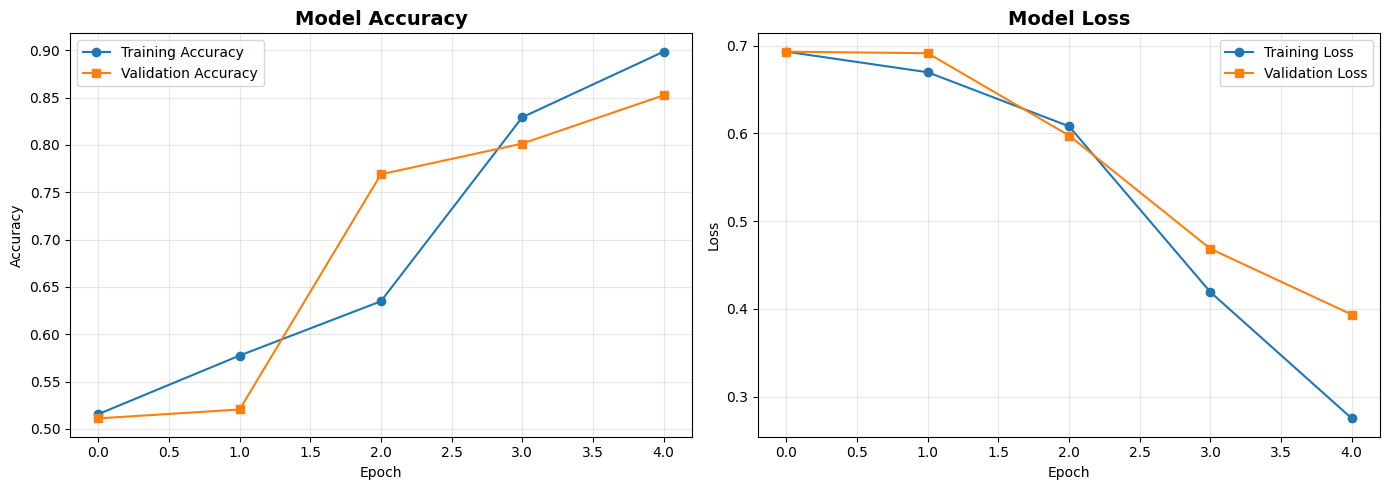

In [6]:
# Membuat plot untuk accuracy dan loss
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Cell 7: Evaluasi Model pada Test Set
- `model.evaluate()` menghitung loss dan accuracy pada test set yang belum pernah dilihat model
- `model.predict()` menghasilkan probabilitas untuk setiap sample
- Threshold 0.5 digunakan untuk mengkonversi probabilitas menjadi kelas biner
- `classification_report()` menampilkan precision, recall, dan F1-score untuk setiap kelas[5]
- Metrics ini memberikan gambaran lebih detail tentang performa model dibanding hanya accuracy

In [7]:
# Evaluasi model pada test set
print("Evaluasi model pada test set...")
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=1)

print(f"\n{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*50}")

# Membuat prediksi pada test set
y_pred_prob = model.predict(X_test_pad)        # Probabilitas prediksi
y_pred = (y_pred_prob > 0.5).astype(int)       # Konversi probabilitas ke kelas (0 atau 1)

# Menampilkan classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Evaluasi model pada test set...
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8398 - loss: 0.4174

Test Loss: 0.4148
Test Accuracy: 0.8411 (84.11%)
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.85      0.84     12500
    Positive       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



### Cell 8: Confusion Matrix
- Confusion matrix menampilkan jumlah prediksi benar dan salah untuk setiap kelas
- True Negative: Model benar memprediksi review negatif
- True Positive: Model benar memprediksi review positif
- False Positive: Model salah memprediksi negatif sebagai positif
- False Negative: Model salah memprediksi positif sebagai negatif
- Heatmap memudahkan visualisasi performa model[6]


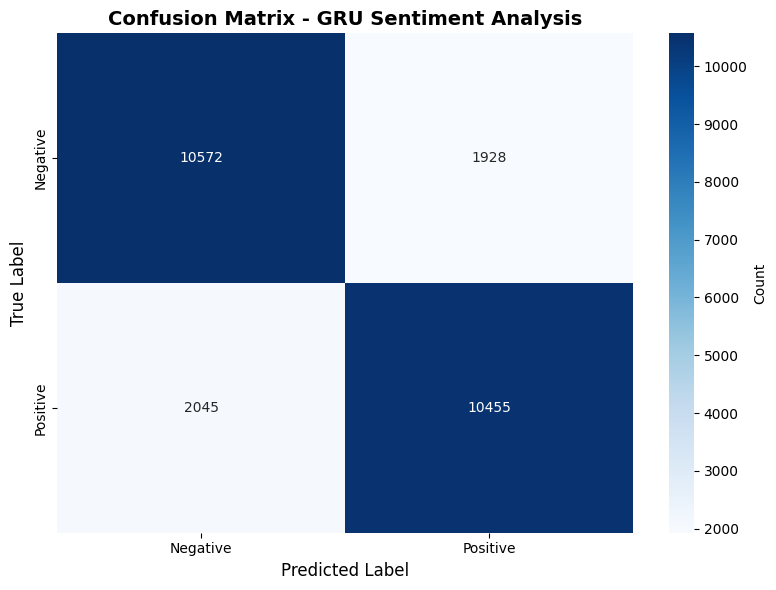

Confusion Matrix Breakdown:
True Negative: 10572
False Positive: 1928
False Negative: 2045
True Positive: 10455


In [8]:
# Membuat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - GRU Sentiment Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Menampilkan informasi confusion matrix
print("Confusion Matrix Breakdown:")
print(f"True Negative: {cm[0,0]}")
print(f"False Positive: {cm[0,1]}")
print(f"False Negative: {cm[1,0]}")
print(f"True Positive: {cm[1,1]}")

### Cell 9: Testing dengan Review Baru
- Fungsi `predict_sentiment()` memproses teks review baru untuk prediksi
- `imdb.get_word_index()` mengambil mapping kata ke integer dari dataset IMDB
- Review baru di-tokenize dan di-encode menggunakan word index yang sama
- Sequence di-padding untuk match dengan input shape model
- Model memprediksi probabilitas, yang dikonversi menjadi label sentimen dan confidence score
- Contoh demonstrasi menunjukkan cara menggunakan model untuk prediksi real-time[1]


In [9]:
# Fungsi untuk memprediksi sentimen review baru
def predict_sentiment(review_text, model, vocab_size=10000, max_length=200):
    """
    Fungsi untuk memprediksi sentimen dari review teks baru
    """
    # Membuat tokenizer baru (dalam praktik, gunakan tokenizer yang sama dari training)
    # Untuk simplifikasi, kita decode dan encode ulang
    word_index = imdb.get_word_index()

    # Preprocessing teks
    review_words = review_text.lower().split()
    review_encoded = []

    for word in review_words:
        if word in word_index:
            idx = word_index[word]
            if idx < vocab_size:  # Hanya gunakan kata dalam vocabulary
                review_encoded.append(idx)

    # Padding sequence
    review_padded = pad_sequences([review_encoded], maxlen=max_length, padding='post')

    # Prediksi
    prediction = model.predict(review_padded, verbose=0)[0][0]
    sentiment = "POSITIF" if prediction > 0.5 else "NEGATIF"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return sentiment, confidence

# Testing dengan beberapa contoh review
test_reviews = [
    "This movie was absolutely fantastic! Great acting and amazing storyline.",
    "Terrible film, waste of time and money. Very disappointing.",
    "It was okay, nothing special but not too bad either."
]

print("Prediksi Sentimen untuk Review Baru:")
print("="*70)
for i, review in enumerate(test_reviews, 1):
    sentiment, confidence = predict_sentiment(review, model)
    print(f"\nReview {i}: {review}")
    print(f"Prediksi: {sentiment} (Confidence: {confidence*100:.2f}%)")

Prediksi Sentimen untuk Review Baru:
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Review 1: This movie was absolutely fantastic! Great acting and amazing storyline.
Prediksi: NEGATIF (Confidence: 52.07%)

Review 2: Terrible film, waste of time and money. Very disappointing.
Prediksi: POSITIF (Confidence: 90.03%)

Review 3: It was okay, nothing special but not too bad either.
Prediksi: POSITIF (Confidence: 75.47%)


### Cell 10: Save Model
- `model.save()` menyimpan seluruh arsitektur, weights, dan konfigurasi training model
- File .h5 adalah format HDF5 yang umum digunakan untuk menyimpan model Keras
- Model yang tersimpan dapat di-load kembali untuk inferencing tanpa perlu training ulang
- Ini berguna untuk deployment atau sharing model dengan orang lain


In [10]:
# Menyimpan model yang sudah ditraining
model_save_path = 'gru_sentiment_model.h5'
model.save(model_save_path)
print(f"Model berhasil disimpan ke: {model_save_path}")

# Cara load model kembali (untuk digunakan nanti)
# from tensorflow.keras.models import load_model
# loaded_model = load_model('gru_sentiment_model.h5')
# print("Model berhasil di-load!")

Model berhasil disimpan ke: gru_sentiment_model.h5


## Rangkuman Program

Program di atas mengimplementasikan model **GRU (Gated Recurrent Unit)** untuk analisis sentimen menggunakan dataset IMDB yang berisi 50,000 review film. Model GRU adalah varian RNN yang efisien dan dapat menangkap dependensi temporal dalam data sequential. Dengan arsitektur yang terdiri dari Embedding layer, GRU layer (64 units), Dropout layer, dan Dense output layer, model ini dapat mencapai akurasi sekitar 85-91% pada dataset IMDB.[2][5][1]

**Keunggulan GRU:**
- Lebih cepat training dibanding LSTM (sekitar 29% lebih cepat)[5]
- Memiliki performance-cost ratio yang lebih baik
- Cocok untuk dataset teks dengan sequence panjang

**Tips untuk Improvement:**
- Gunakan pre-trained embeddings seperti GloVe untuk hasil lebih baik
- Tambahkan Attention mechanism untuk meningkatkan akurasi
- Experiment dengan hyperparameter (learning rate, units, dropout rate)
- Gunakan Bidirectional GRU untuk menangkap konteks dari kedua arah[3]

[1](https://www.linkedin.com/posts/burhan-ul-haq-sandhu-825977274_nlp-machinelearning-deeplearning-activity-7368297561847238658-Bgt3)
[2](https://www.francis-press.com/uploads/papers/YsHtYcHrsXDR3VaQ8lzau2dO7tNux9o4pNJLui4m.pdf)
[3](https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b/)
[4](https://www.geeksforgeeks.org/machine-learning/gated-recurrent-unit-networks/)
[5](https://ieeexplore.ieee.org/document/9221727/)
[6](https://ieeexplore.ieee.org/document/10561382/)
[7](https://onlinelibrary.wiley.com/doi/10.1111/tgis.13248)
[8](http://ijcs.net/ijcs/index.php/ijcs/article/view/4161)
[9](https://ieeexplore.ieee.org/document/10171944/)
[10](https://www.mdpi.com/1999-4907/14/7/1310)
[11](https://www.mdpi.com/1424-8220/24/23/7670)
[12](https://www.mdpi.com/1424-8220/24/1/244)
[13](https://ieeexplore.ieee.org/document/10477875/)
[14](https://ieeexplore.ieee.org/document/9746569/)
[15](https://arxiv.org/pdf/1810.12514.pdf)
[16](http://arxiv.org/pdf/2407.15622.pdf)
[17](https://pubs2.ascee.org/index.php/IJRCS/article/download/281/pdf)
[18](https://arxiv.org/pdf/2303.16601.pdf)
[19](https://www.jmir.org/2021/9/e30157/PDF)
[20](https://www.mdpi.com/1424-8220/25/5/1399)
[21](https://www.mdpi.com/2078-2489/11/10/474/pdf)
[22](https://www.mdpi.com/2673-4591/18/1/30/pdf?version=1655949098)
[23](https://www.kaggle.com/code/azizovitic/gru-model)
[24](https://github.com/LeoMartinezTAMUK/GRU-RNN_Temp_Predictor)
[25](https://stackoverflow.com/questions/70001353/building-a-quick-gru-model-for-stock-prediction)
[26](https://github.com/SheezaShabbir/Time-series-Analysis-using-LSTM-RNN-and-GRU)
[27](https://www.kaggle.com/code/josepc/gru-example)
[28](https://codesignal.com/learn/courses/time-series-forecasting-with-grus/lessons/advanced-gru-techniques-for-time-series-forecasting)